In [24]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import datasets

In [25]:
#load data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# TPU or GPU detection

In [26]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, ZeroPadding2D
from tensorflow.keras.regularizers import l2

with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), 
                     input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

#     opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("model_checkpoint.h5", 
                             monitor='val_loss', mode='min', 
                             save_best_only=True, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, patience=10, 
                               verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)


history = model.fit(X_train, y_train, epochs=100, 
                    batch_size= 128,
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
391/391 [==============================] - 23s 46ms/step - loss: 2.9405 - accuracy: 0.3938 - val_loss: 2.3985 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 16s 41ms/step - loss: 2.1415 - accuracy: 0.5722 - val_loss: 1.8267 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 16s 41ms/step - loss: 1.7204 - accuracy: 0.6555 - val_loss: 1.5620 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 16s 41ms/step - loss: 1.4498 - accuracy: 0.7006 - val_loss: 1.3180 - val_accuracy: 0.7231 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 16s 41ms/step - loss: 1.2794 - accuracy: 0.7314 - val_loss: 1.2102 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 16s 41ms/step - loss: 1.1754 - accuracy: 0.7513 - val_loss: 1.1297 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 7/100
391/391 [==============================]

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 13ms/step - loss: 0.6289 - accuracy: 0.8801


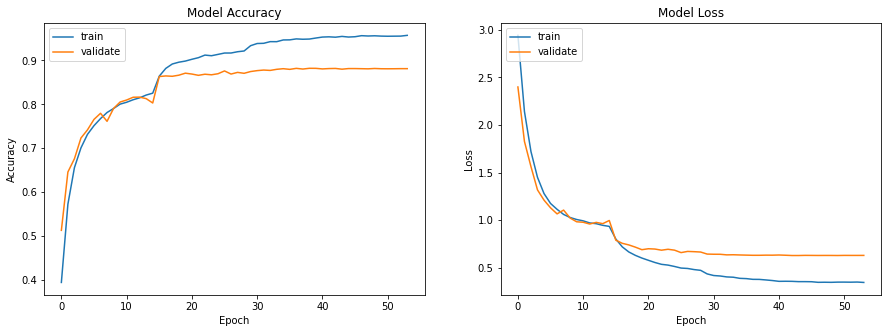

In [30]:
import matplotlib.pyplot as plt
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

plotmodelhistory(history)

In [31]:
from tensorflow.keras import models
models.save_model(model,'CNN_model.hdf5')

CNN_model = models.load_model('./CNN_model.hdf5')

test_loss, test_acc = CNN_model.evaluate(X_test , y_test, batch_size= 128, verbose=2)
print("test_loss = ", test_loss)
print("test_acc = ", test_acc)

79/79 - 1s - loss: 0.6289 - accuracy: 0.8801 - 1s/epoch - 15ms/step
test_loss =  0.628913402557373
test_acc =  0.8801000118255615
